### Developing  a machine learning classification model to predict the category of news articles based on their headlines

### Dataset description:


### This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

### Each record in the dataset consists of the following attributes:

### category: category in which the article was published.
### headline: the headline of the news article.
### authors: list of authors who contributed to the article.
### link: link to the original news article.
### short_description: Abstract of the news article.
### date: publication date of the article.
### There are a total of 42 news categories in the dataset. 

In [7]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2, SelectKBest

In [2]:
# Load the JSON lines file into a Pandas DataFrame
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [4]:
# Count unique values in categorical columns like 'category', 'authors', etc.
print(df['category'].value_counts())
print(df['authors'].value_counts().head(10)) 


POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [5]:
# Check for missing values
print(df.isnull().sum())

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64


### EDA:


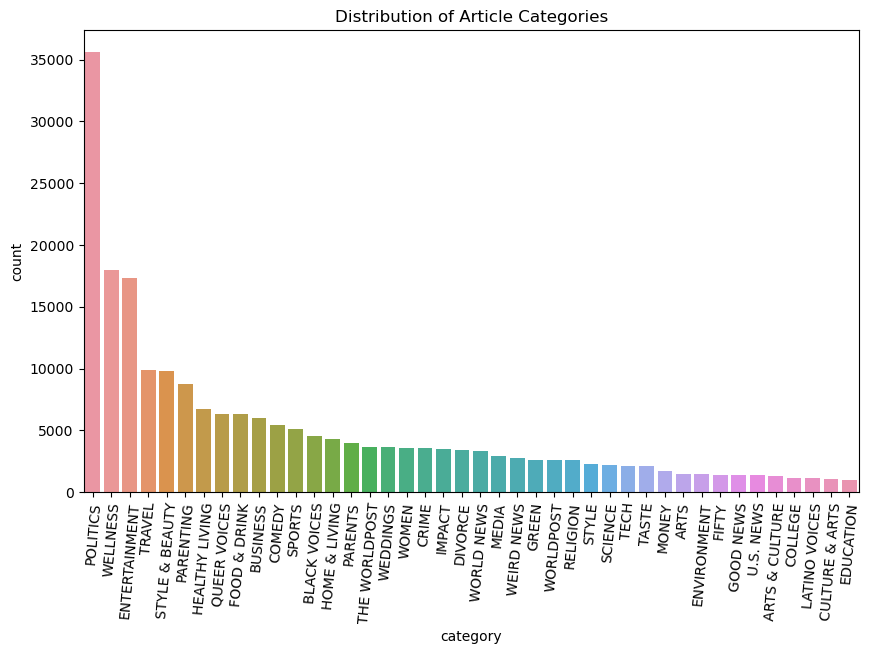

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#Distribution of article categories
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=df, order=df['category'].value_counts().index)
plt.xticks(rotation=85)
plt.title('Distribution of Article Categories')
plt.show()


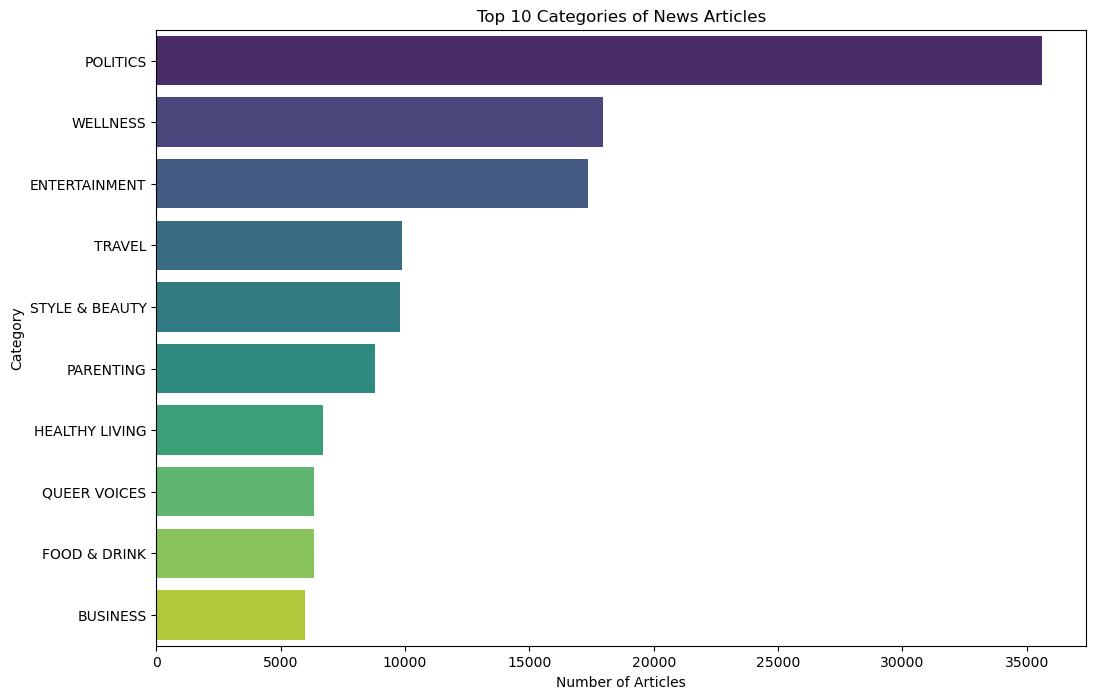

In [7]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Select the top 10 categories
top_categories = category_counts.head(10)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')

# Add labels and title
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.title('Top 10 Categories of News Articles')

# Show the plot
plt.show()

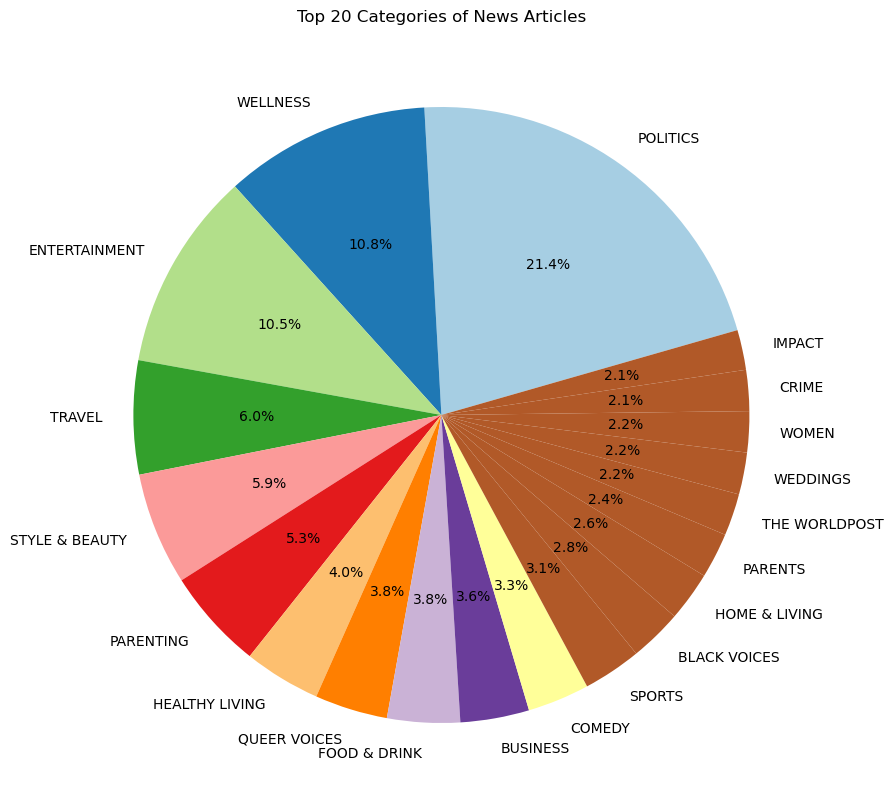

In [8]:
# Select the top 20 categories
top_categories = category_counts.head(20)

# Create a pie chart
plt.figure(figsize=(12, 10))
plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%', startangle=16, colors=plt.cm.Paired(range(20)))

# Add a title
plt.title('Top 20 Categories of News Articles')

# Show the plot
plt.show()

In [9]:
pip install wordcloud matplotlib


Note: you may need to restart the kernel to use updated packages.


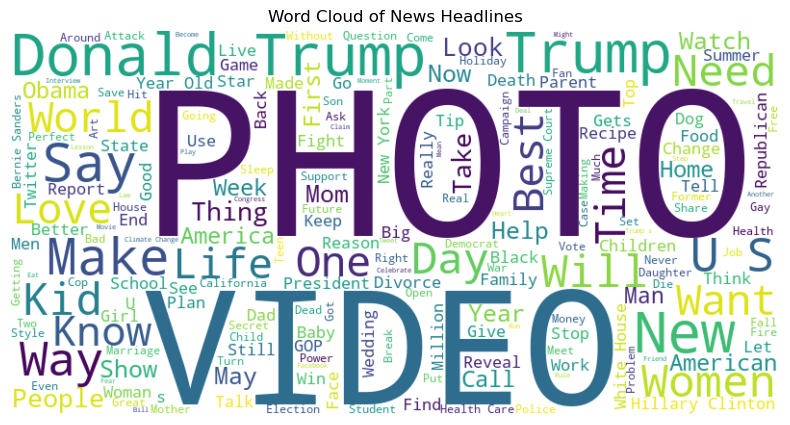

In [10]:
from wordcloud import WordCloud
# Combine all article content into a single string
text = ' '.join(df['headline'].astype(str))  # Use 'headline' or another relevant column

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of News Headlines')
plt.show()

# Random Forest: 
### Random Forest is an ensemble learning method used primarily for classification and regression tasks. It builds multiple decision trees during training and merges their predictions to improve accuracy and control overfitting. Each tree in the forest is trained on a random subset of the data with random subsets of features, which helps to ensure diversity among the trees. The final prediction is made by averaging the outputs (for regression) or by taking a majority vote (for classification) from all the trees in the forest.

### Lemmatization is a text normalization process in Natural Language Processing (NLP) that reduces words to their base or root form, known as a lemma.

### Vectorization is the process of converting text data into numerical vectors that can be used by machine learning algorithms. 

### Vectorization with Bigrams extends the basic vectorization approach by including pairs of consecutive words (bigrams) in the feature representation. Instead of considering individual words alone, this method captures contextual information by accounting for word pairs, which can provide additional insights into the structure and meaning of the text. For example, in the sentence "the cat sat," bigrams would include "the cat" and "cat sat." This approach can improve model performance by capturing relationships and patterns between words that single-word vectorization might miss.

### Text pre-processing 

In [11]:
# Enhanced text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()  # Split into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(words)  # Join words back into a single string

# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)


### Train-test split

In [12]:
# Train-test split
X = df['processed_headline']
y = df['category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Vectorization

In [13]:
# Vectorization with bigrams
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit and transform on training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform validation data
X_val_vec = vectorizer.transform(X_val)

print("Shape of X_train_vec:", X_train_vec.shape)
print("Shape of X_val_vec:", X_val_vec.shape)


Shape of X_train_vec: (167621, 10000)
Shape of X_val_vec: (41906, 10000)


### Address-class imbalance
### SMOTE (Synthetic Minority Over-sampling Technique) is a popular method for addressing class imbalance in machine learning, particularly when dealing with classification tasks where one class is significantly underrepresented compared to another. Class imbalance can lead to biased models that perform poorly on the minority class because the model might be skewed towards predicting the majority class.

In [14]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)


### Feature-selection

In [15]:
# Feature selection using chi-squared test
chi2_selector = SelectKBest(chi2, k=3000)
X_train_kbest = chi2_selector.fit_transform(X_train_res, y_train_res)
X_val_kbest = chi2_selector.transform(X_val_vec)


### Model training(Random Forest)

In [16]:
# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

# Initialize GridSearchCV with Random Forest
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)

# Train the model with selected features
grid_search.fit(X_train_kbest, y_train_res)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on validation set
y_pred = best_model.predict(X_val_kbest)

# Evaluate model performance
print(classification_report(y_val, y_pred))


                precision    recall  f1-score   support

          ARTS       0.26      0.12      0.16       293
ARTS & CULTURE       0.19      0.16      0.17       275
  BLACK VOICES       0.47      0.21      0.29       889
      BUSINESS       0.59      0.10      0.17      1216
       COLLEGE       0.20      0.43      0.28       202
        COMEDY       0.38      0.31      0.34      1022
         CRIME       0.35      0.43      0.38       713
CULTURE & ARTS       0.49      0.33      0.39       202
       DIVORCE       0.80      0.50      0.61       664
     EDUCATION       0.18      0.42      0.25       209
 ENTERTAINMENT       0.84      0.04      0.08      3419
   ENVIRONMENT       0.40      0.19      0.26       313
         FIFTY       0.27      0.08      0.12       263
  FOOD & DRINK       0.58      0.30      0.39      1270
     GOOD NEWS       0.18      0.13      0.15       270
         GREEN       0.21      0.16      0.18       532
HEALTHY LIVING       0.10      0.09      0.09  

### The current model(Random Forest) demonstrates limited effectiveness in accurately classifying news headlines into their respective categories, achieving an overall accuracy of 32%.  This indicates that there is substantial room for improvement

# Logistic Regression

### Logistic regression is a fundamental classification algorithm in machine learning that is particularly effective for Natural Language Processing (NLP) classification tasks due to its simplicity and interpretability. It works by modeling the probability of a binary outcome based on one or more predictor variables using the logistic function, which transforms the linear combination of features into a probability value between 0 and 1. In the context of NLP, features are often derived from text data through techniques like bag-of-words or TF-IDF (Term Frequency-Inverse Document Frequency). Logistic regression excels in these scenarios because it can efficiently handle high-dimensional, sparse datasets common in text data, and it provides a clear probabilistic framework for classification. Additionally, its ability to output probabilities makes it valuable for tasks like sentiment analysis or spam detection, where understanding the likelihood of different classes can be crucial. Its relative ease of implementation and low computational cost further contribute to its popularity in NLP applications.

In [16]:
from sklearn.linear_model import LogisticRegression

### Model building(Logistic Regression)

In [19]:
# Initialize and train Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_kbest, y_train_res)

# Predict on validation set
y_pred_lr = logistic_regression_model.predict(X_val_kbest)

# Evaluate model performance
print(classification_report(y_val, y_pred_lr))


                precision    recall  f1-score   support

          ARTS       0.04      0.33      0.07       293
ARTS & CULTURE       0.14      0.28      0.19       275
  BLACK VOICES       0.37      0.34      0.35       889
      BUSINESS       0.42      0.32      0.36      1216
       COLLEGE       0.25      0.51      0.33       202
        COMEDY       0.48      0.43      0.45      1022
         CRIME       0.39      0.51      0.44       713
CULTURE & ARTS       0.18      0.44      0.26       202
       DIVORCE       0.69      0.68      0.68       664
     EDUCATION       0.17      0.44      0.24       209
 ENTERTAINMENT       0.70      0.39      0.50      3419
   ENVIRONMENT       0.22      0.39      0.28       313
         FIFTY       0.11      0.24      0.15       263
  FOOD & DRINK       0.61      0.52      0.56      1270
     GOOD NEWS       0.15      0.34      0.21       270
         GREEN       0.29      0.32      0.30       532
HEALTHY LIVING       0.26      0.25      0.25  

### The accuracy for Logistic Regression model is 45%. This model is better than random forest due to spike in accuracy and this accuracy can also be increased more by employing more sophisticated tuning methods.

In [30]:
# Define a function to predict the category of a new headline
def predict_category(headline):
    # Preprocess the new headline
    processed_headline = preprocess_text(headline)
    
    # Vectorize the new headline
    headline_vec = vectorizer.transform([processed_headline])
    
    # Apply the same feature selection
    headline_kbest = chi2_selector.transform(headline_vec)
    
    # Predict the category
    prediction = logistic_regression_model.predict(headline_kbest)
    
    # Return the predicted category
    return prediction[0]

# Example usage: Predict the category of a new headline
new_headline = input("Enter a news headline: ")
predicted_category = predict_category(new_headline)
print(f'Predicted Category: {predicted_category}')

Enter a news headline: "New Study Reveals the Benefits of Daily Exercise for Mental Health"
Predicted Category: WELLNESS
